In [ ]:
import pandas as pd
import numpy as np

#import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import Pipeline


#pre-processing of text
import string
import re
import requests

#import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# SK Learn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

#import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score

# Misc
import warnings
from sys import modules
from time import time
from platform import python_version

from mpl_toolkits.mplot3d import Axes3D

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# IPython
from IPython.display import Image, display

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, WordNetLemmatizer
from nltk.probability import FreqDist
from textblob import TextBlob
from gensim.corpora import Dictionary
from gensim import matutils, models
import scipy.sparse
import spacy
from spacy import displacy
from collections import Counter
nlp = spacy.load('en_core_web_sm')

#<! Installing updated version of XGBoost
# !pip uninstall --yes xgboost
# !pip install xgboost
import xgboost as xgb

# Confuguration
warnings.filterwarnings('ignore')
%matplotlib inline


Sentiments prediction from Tweets about Covid-19

# 1. Problem Definition
A Gonvernmental research institution would like to know how people around the world felt about the Corona virus situation, in order to see if English tweets of Israelies will be more positive or negetive, in case of Covid-21. 
The goal is check how likely for a common Israeli tweeter to be positive or negativeabout another Covid situation


# 2. The data
The data is taken from Kaggle: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification



In [ ]:
tweets = pd.read_csv("Corona_NLP.csv",encoding='latin-1')
tweets.sample(7)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4850,8649,53601,The World's Private Detective,18-03-2020,"#Opinion:\r\r\n\r\r\nPlease Government,\r\r\n\...",Positive
6380,10179,55131,NaN,19-03-2020,Online shopping is increasing this week with t...,Extremely Positive
1440,5239,50191,"Buenos Aires, Argentina",17-03-2020,#Amazon delivery infrastructure strained as #C...,Negative
16896,20695,65647,"Dunedin, Otago, New Zealand",23-03-2020,Thank you to all our doctors nurses midwives h...,Negative
28006,31805,76757,NaN,4/4/2020,Lady in front of me in supermarket queue: ÂTh...,Positive
9909,13708,58660,"Enderby, England",20-03-2020,A man wearing a #hazmat suit was witnessed cas...,Positive
8427,12226,57178,United States,19-03-2020,Finally found enough toilet tissue to last a f...,Neutral


In [ ]:
#Creating Dataframe object
df = pd.DataFrame(tweets)

In [ ]:
#Obtainning info about the data frame:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.1+ MB


(44955, 6)

In [ ]:
df.nunique()

UserName         44955
ScreenName       44955
Location         13127
TweetAt             44
OriginalTweet    44955
Sentiment            5
dtype: int64




```

# 3. Exploring the data

In [ ]:
df["Location"].nunique()

13127

In [ ]:
df["TweetAt"].nunique()

44

In [ ]:
df["Sentiment"].value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

In [ ]:
df["Sentiment"].count()

44955

In [ ]:
df["TweetAt"].sample(10)

11932    20-03-2020
10336    20-03-2020
44290    15-03-2020
24220    26-03-2020
13947    21-03-2020
38601     11/4/2020
39360     12/4/2020
30089      6/4/2020
20889    25-03-2020
30091      6/4/2020
Name: TweetAt, dtype: object

# 4. Data Preprocessing

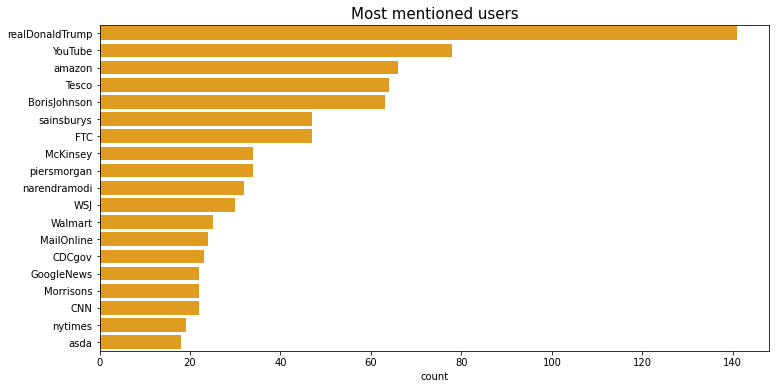

In [ ]:
#Top mentioned Users
df['mention_user'] = df.OriginalTweet.str.findall(r'(?<![@\w])@(\w{1,25})').apply(','.join)
mentions_count = (df.mention_user.value_counts()[1:20]
                  .to_frame().reset_index()
                  .rename(columns={"index": "mention_user", "mention_user": "count"}))
plt.figure(figsize=(12,6))
sns.barplot(x=mentions_count['count'],y=mentions_count['mention_user'], color='orange');
plt.title("Most mentioned users", size=15);plt.ylabel('');

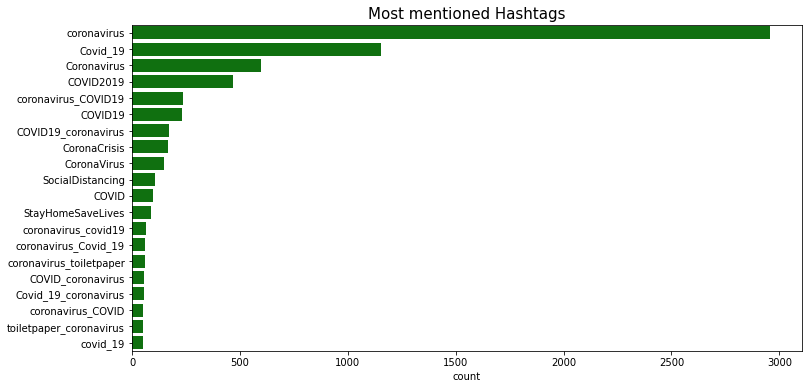

In [ ]:
#Top mentioned Hashtags
df['hashtags'] = df.OriginalTweet.str.findall(r'(?<![#\w])#(\w{1,50})').apply('_'.join)
mentionsH_count = (df.hashtags.value_counts()[1:21]
                  .to_frame().reset_index()
                  .rename(columns={"index": "hashtags", "hashtags": "count"}))
plt.figure(figsize=(12,6))
sns.barplot(x=mentionsH_count['count'],y=mentionsH_count['hashtags'], color='g');
plt.title("Most mentioned Hashtags", size=15);plt.ylabel('');

In [ ]:
df.hashtags.nunique()

17417

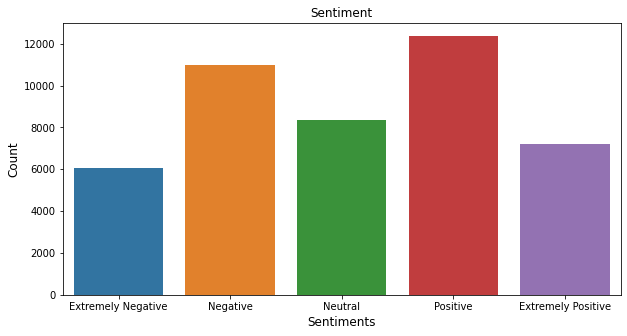

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='Sentiment', data=df, order=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'])
plt.title("Sentiment")
plt.ylabel("Count", fontsize = 12)
plt.xlabel("Sentiments",fontsize = 12)
plt.show()

# 5. Feature Engineering

In [ ]:
#Dropping Neutral
df = df.loc[df["Sentiment"] != 'Neutral']

#Binarizing the sentiment labels
df['Sentiment'] = df['Sentiment'].replace(['Extremely Negative','Extremely Positive'],['Negative', 'Positive'])

In [ ]:
df.shape

(36623, 8)

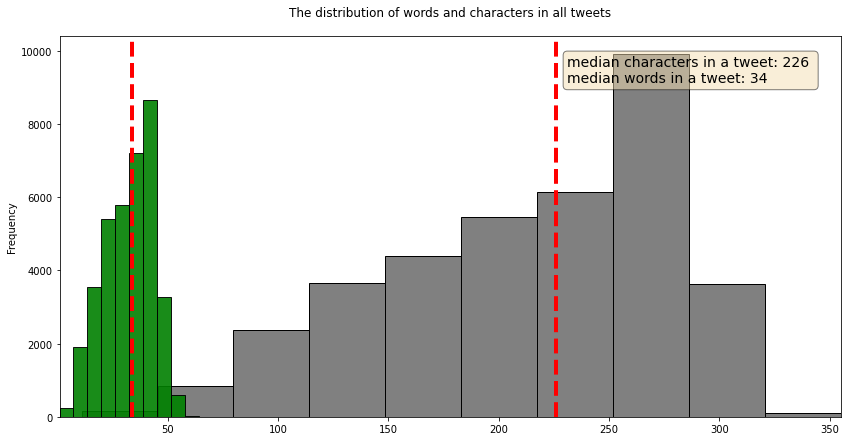

In [ ]:
#Adding words and characters lengths
df['tweet_len'] = df['OriginalTweet'].map(lambda x: len(x))
df['tweet_n_words'] = df['OriginalTweet'].map(lambda x: len(x.split()))
fig, ax = plt.subplots(figsize=(14,7))
df.tweet_len.plot(kind='hist',color='grey',edgecolor="k");
df.tweet_n_words.plot(kind='hist',color='g',edgecolor="k", alpha=0.9);
plt.axvline(df['tweet_len'].median(), ls = '--',color='r',lw=4);
plt.axvline(df['tweet_n_words'].median(), ls = '--',color='r',lw=4);
textstr = (f"median characters in a tweet: {round(df['tweet_len'].median())} \n"
           f"median words in a tweet: {round(df['tweet_n_words'].median())}")  
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5,edgecolor='black')
plt.text(0.65, 0.95, textstr, fontsize=14,transform=ax.transAxes,verticalalignment='top', bbox=props)
plt.title("The distribution of words and characters in all tweets", pad=20);plt.margins(x=0);

Words and Characters per tweet

In [ ]:
#Dropping NaN 
df['Location'] = df['Location'].dropna(axis=0, how='any', inplace=False)

In [ ]:
df = df[df.Location != 'earth']
df = df[df.Location != 'The World']
df = df[df.Location != 'hell']
df = df[df.Location != r'[\**\#*\<*\>*\@*\.*(\w)\**\#*\<*\>*\@*\.*]']
df = df[df.Location != r'\?.[A-Z\a-z]*\?.']
df = df[df.Location != r'*[0-9](\w)']
df = df = df[~df.Location.str.contains('Nan', na=True)]
df = df = df[~df.Location.str.contains(r'\?.[A-Z\a-z]*\?.')]
df = df[df.Location != 'N/a']

df.Location.sample(20)

1426                    London, UK
22710              California, USA
38722                          UAE
20001             N Qld, Australia
2183                 Los Altos, CA
5965                       Toronto
38181                     Virginia
9014             Airdrie, Scotland
6083       England, United Kingdom
28188              New Jersey, USA
31818                       London
13777                United States
17607          North Carolina, USA
27594                United States
2512      ÃT: -26.10139,28.056968
39093                United States
14089               Santa Cruz, CA
41416    San Francisco, California
44708                  Philippines
40498               Greenville, NC
Name: Location, dtype: object

In [ ]:
df.shape

(28501, 10)

In [ ]:
df.sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,mention_user,hashtags,tweet_len,tweet_n_words
21076,24875,69827,South Africa,25-03-2020,This is what our dignity packs looks like and ...,Positive,,,245,48
6636,10435,55387,"Canada, eh?",19-03-2020,Next week I'll be hitting the grocery store li...,Positive,,COVID19ON_CoronaVirusUpdate_coronavirus_Convid19,125,14
103,3902,48854,USA,16-03-2020,This also needs to be said: going to the groce...,Positive,,coronavirus,284,51
33739,37538,82490,"Sydney, New South Wales",8/4/2020,An argument from the World Bank about the impo...,Positive,,,211,34
2829,6628,51580,Coffee Cooking Concerts Rock!,18-03-2020,I feel disgusted... Some people have no family...,Negative,,coronavirus_panicbuyers,282,50
26335,30134,75086,Southern England,2/4/2020,has today proposed a range of temporary measur...,Positive,,,188,34
34555,38354,83306,"Little Rock, Arkansas, USA",8/4/2020,Analysts say retailers are struggling to meet ...,Positive,,,261,34
18729,22528,67480,Centre County Pa,23-03-2020,With gas prices dropping so low. I see a huge ...,Positive,,coronavirus,274,55
10370,14169,59121,Lagos,20-03-2020,"Nigerian Stocks Suffer Another Loss, ASI Dips ...",Negative,,,141,17
40383,44182,89134,United States,13-04-2020,How to Make Clorox Bleach Wipes &amp; DIY Hand...,Positive,,coronavirus_californiacoronavirus_COVID19_coro...,191,24


In [ ]:
df['OriginalTweet'].values

array(['advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P',
       'As news of the regionÂ\x92s first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU',
       ...,
       'Meanwhile In A Supermarket in Israel -- People dance and sing together to stay positive. ? #CoronaVirus https://t.co/VLLqGI3R16',
       "Did you panic buy a lot of non-perishable items? ECHO needs food donations. It is also looking for volunteers to pack boxes. Volunteers will be screened to be sure they don't have COVID-19

Creating words cloud

In [ ]:
# Extracting only the Tweet text from the df
Tweet_texts = df['OriginalTweet'].values

# Converting the text column as a single string for wordcloud
Tweets_String = str(Tweet_texts)
 
# Converting the whole text to lowercase
Tweet_Texts_Cleaned = Tweets_String.lower()
 
# Removing the twitter usernames from tweet string
Tweet_Texts_Cleaned = re.sub(r'@\w+', ' ', Tweet_Texts_Cleaned)
 
# Removing the URLS from the tweet string
Tweet_Texts_Cleaned = re.sub(r'http\S+', ' ', Tweet_Texts_Cleaned)
 
# Deleting everything which is not letters or numbers
Tweet_Texts_Cleaned = re.sub(r'[^a-zA-Z0-9]', ' ',Tweet_Texts_Cleaned)
 
# Deleting any word which is less than 3-characters mostly those are stopwords
Tweet_Texts_Cleaned= re.sub(r'\b\w{1,2}\b', '', Tweet_Texts_Cleaned)
 
# Stripping extra spaces in the text
Tweet_Texts_Cleaned= re.sub(r' +', ' ', Tweet_Texts_Cleaned)
 
Tweet_Texts_Cleaned

' advice talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular meds but not over order coronavirus australia woolworths give elderly disabled dedicated shopping hours amid covid outbreak news the region x92s first confirmed covid case came out sullivan county last week people flocked area stores purchase cleaning supplies hand sanitizer food toilet paper and other goods reports meanwhile supermarket israel people dance and sing together stay positive coronavirus did you panic buy lot non perishable items echo needs food donations also looking for volunteers pack boxes volunteers will screened sure they don have covid and members are committed the safety our employees and our end users are monitoring covid rest assured that tissue manufacturers are continuing produce and ship products '

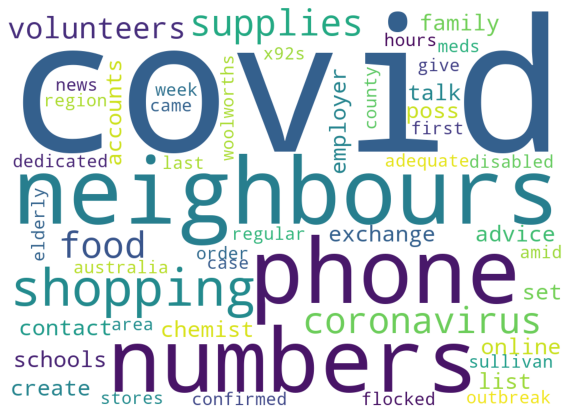

In [ ]:
# Plotting the wordcloud 
# Creating the custom stopwords
customStopwords=list(STOPWORDS)+ ['cases','corona','virus','people','will']
 
wordcloudimage = WordCloud(
                          max_words=50,
                          max_font_size=400,
                          font_step=3,
                          stopwords=customStopwords,
                          background_color='white',
                          width=1000,
                          height=720
                          ).generate(Tweet_Texts_Cleaned)
 
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(wordcloudimage)
wordcloudimage
plt.show()

Most used words

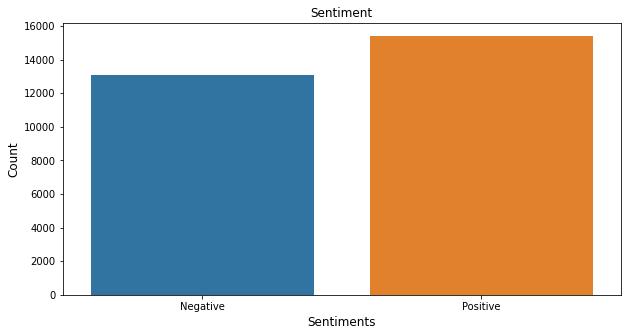

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='Sentiment', data=df, order=['Negative', 'Positive'])
plt.title("Sentiment")
plt.ylabel("Count", fontsize = 12)
plt.xlabel("Sentiments",fontsize = 12)
plt.show()

The data is balanced and has enough values

In [ ]:
#Checking nulls
df.isnull().sum().sort_values()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
mention_user     0
hashtags         0
tweet_len        0
tweet_n_words    0
dtype: int64

In [ ]:
df['OriginalTweet'].describe

<bound method NDFrame.describe of 1        advice Talk to your neighbours family to excha...
2        Coronavirus Australia: Woolworths to give elde...
5        As news of the regionÂs first confirmed COVID...
6        Cashier at grocery store was sharing his insig...
8        Due to COVID-19 our retail store and classroom...
                               ...                        
44948    With Gov Hogan's announcement that all bars, r...
44949    @RicePolitics @MDCounties Craig, will you call...
44950    Meanwhile In A Supermarket in Israel -- People...
44951    Did you panic buy a lot of non-perishable item...
44954    I and @ForestandPaper members are committed to...
Name: OriginalTweet, Length: 28501, dtype: object>

In [ ]:
df[['OriginalTweet','Sentiment']].sample(5)

,OriginalTweet,Sentiment
5442,Coronavirus Minister says there isn t a shorta...,Negative
9742,Exciting applause and messages of encouragemen...,Positive
36821,The CDC recommends most people wear cloth face...,Positive
30035,A quick look at the impact of Covid-19 on fres...,Positive
42807,PUBLIC SERVICE ANNOUNCEMENT: Cannabis does not...,Positive


#6. Splitting the data

In [ ]:
#Vectorizing and Splitting Tweets and sentimnts

X = df['OriginalTweet']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#7. Vectorizing with  TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train) 
X_train_tfidf.shape

(19095, 46372)

# 8. Running the model

LinearSVC

In [ ]:
clf = LinearSVC()
clf.fit(X_train_tfidf,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

In [ ]:
# Form a prediction set
predictions = text_clf.predict(X_test)

In [ ]:
# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions))

[[3660  638]
 [ 563 4545]]


In [ ]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

    Negative       0.87      0.85      0.86      4298
    Positive       0.88      0.89      0.88      5108

    accuracy                           0.87      9406
   macro avg       0.87      0.87      0.87      9406
weighted avg       0.87      0.87      0.87      9406



In [ ]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.8723155432702531


Gradient boosting classifier

In [ ]:
clf_GB = GradientBoostingClassifier(max_depth = 5, n_estimators = 200, learning_rate = 0.01, random_state = 1234)
clf_GB.fit(X_train_tfidf, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1234, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
text_clf_GB = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', GradientBoostingClassifier(max_depth = 5, n_estimators = 200, learning_rate = 0.01, random_state = 1234)),
])

# Feed the training data through the pipeline
text_clf_GB.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                            learning_rate=0.01, loss='deviance',
                                            max_depth=5, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
         

In [ ]:
# Form a prediction set
predictions = text_clf_GB.predict(X_test)

In [ ]:
# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions))

[[1528 2770]
 [ 370 4738]]


In [ ]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

    Negative       0.81      0.36      0.49      4298
    Positive       0.63      0.93      0.75      5108

    accuracy                           0.67      9406
   macro avg       0.72      0.64      0.62      9406
weighted avg       0.71      0.67      0.63      9406



In [ ]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.6661705294492877


Decision Tree Classifier

In [ ]:
clf_DT = DecisionTreeClassifier(max_depth = 3, random_state = 1234)
clf_DT.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')

In [ ]:
text_clf_DT = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', DecisionTreeClassifier(max_depth = 3, random_state = 1234)),
])

# Feed the training data through the pipeline
text_clf_DT.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=3,
                  

In [ ]:
# Form a prediction set
predictions = text_clf_DT.predict(X_test)

In [ ]:
# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions))

[[ 893 3405]
 [ 185 4923]]


In [ ]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

    Negative       0.83      0.21      0.33      4298
    Positive       0.59      0.96      0.73      5108

    accuracy                           0.62      9406
   macro avg       0.71      0.59      0.53      9406
weighted avg       0.70      0.62      0.55      9406



In [ ]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.6183287263448862
